In [1]:
# Portfolio: Health Insurance Cost Analysis
# Author: YI LUO
# Date: 2025-04-24
# Data Source: https://www.kaggle.com/datasets/mirichoi0218/insurance/data
#
# Introduction:
# In this notebook, we conduct a full exploratory and predictive analysis 
# of individual health insurance costs for 1,338 U.S. policyholders. We begin 
# with data ingestion and cleaning, then perform univariate and bivariate 
# visualizations to uncover key patterns: smokers incur substantially higher 
# charges, and costs rise with age and BMI. Next, we engineer features—
# including directional region flags—and build two models (linear regression 
# and random forest) to predict charges. The random forest achieves over 20% 
# lower RMSE than the linear baseline, highlighting its ability to capture 
# non-linear effects. Finally, we run residual diagnostics and extract 
# feature importances, confirming smoking status, BMI, and age as the 
# strongest drivers of insurance costs. This end-to-end workflow demonstrates 
# best practices in data analysis, modeling, and interpretation.


In [2]:
# Section 1: Setup & Data Loading

# 1.1 — Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.2 — Plot styling
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

# 1.3 — Load data
DATA_PATH = './insurance.csv'
df = pd.read_csv(DATA_PATH)

# 1.4 — Quick peek
print(f"Dataset shape: {df.shape}")
display(df.head())


Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Section 2: Data Overview & Cleaning

# 2.1 — Missing values & dtypes
print("Missing values:\n", df.isna().sum())
print("\nData types:\n", df.dtypes)

# 2.2 — Convert to appropriate types
for col in ['sex', 'smoker', 'region']:
    df[col] = df[col].astype('category')

# 2.3 — Summary stats
display(df.describe(include='all').T)


Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Data types:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [4]:
# Section 3: EDA Helper Functions

def plot_numeric_distribution(data, cols):
    """Histogram + KDE for numeric columns."""
    for c in cols:
        sns.histplot(data[c], kde=True)
        plt.title(f"Distribution of {c.capitalize()}")
        plt.xlabel(c.capitalize())
        plt.ylabel("Count")
        plt.show()

def plot_categorical_counts(data, cols):
    """Countplot for categorical columns."""
    for c in cols:
        sns.countplot(x=c, data=data)
        plt.title(f"Count by {c.capitalize()}")
        plt.xlabel(c.capitalize())
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()


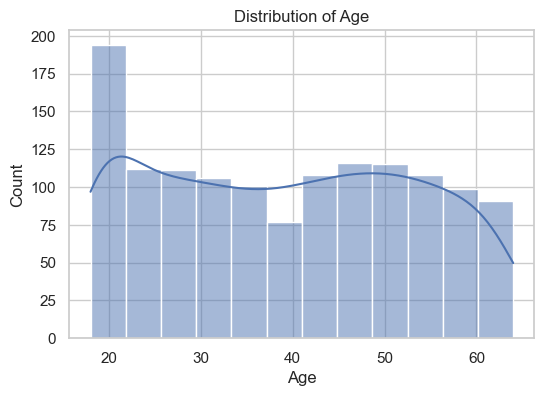

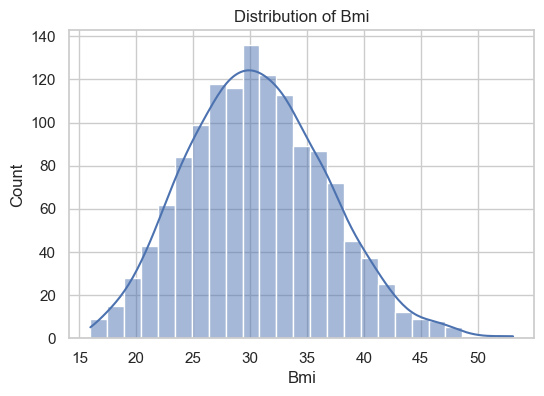

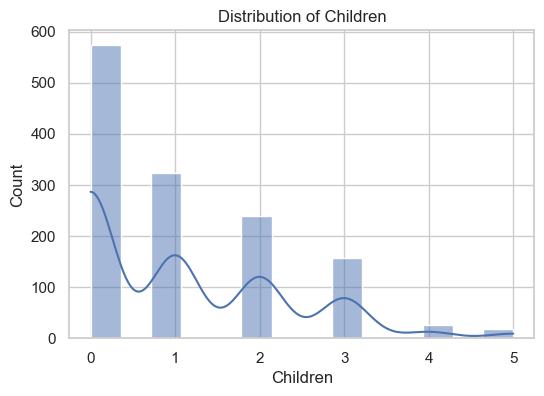

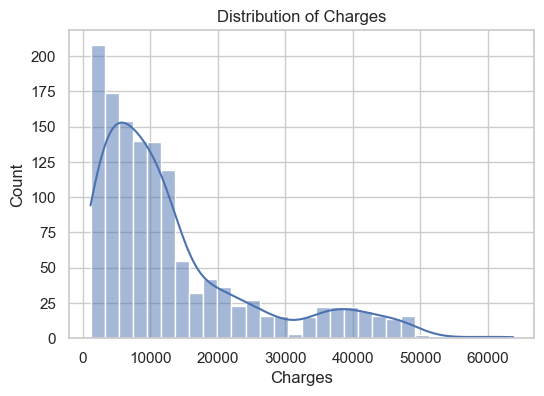

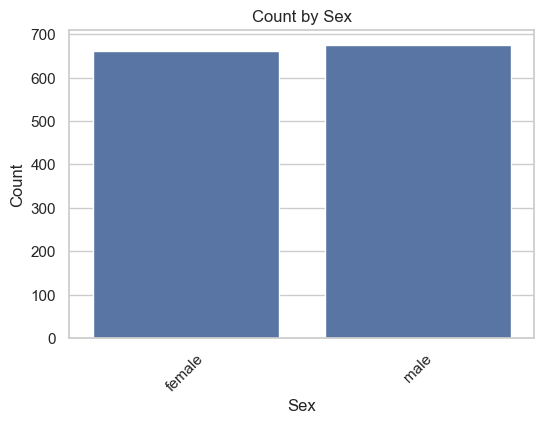

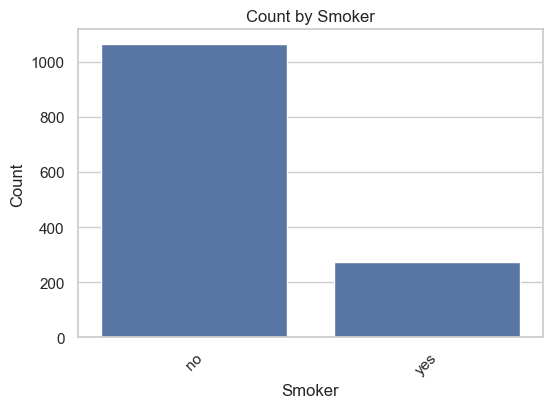

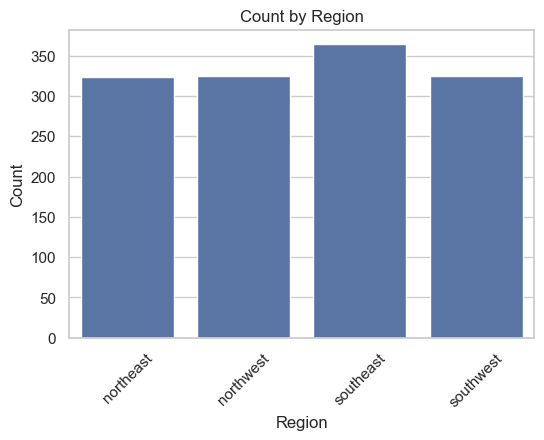

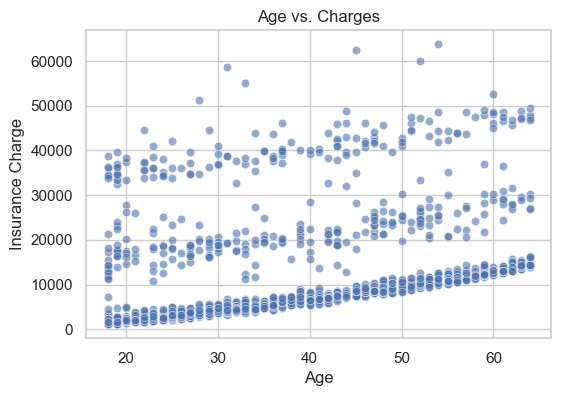

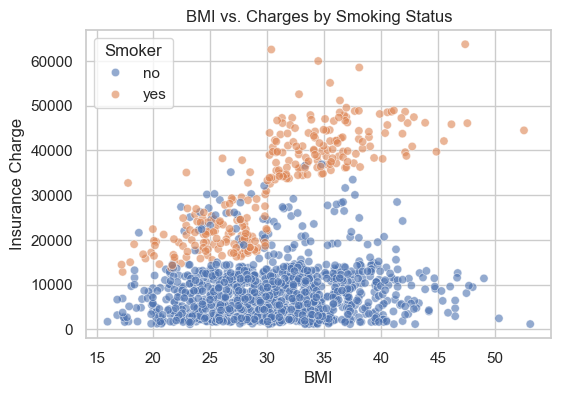

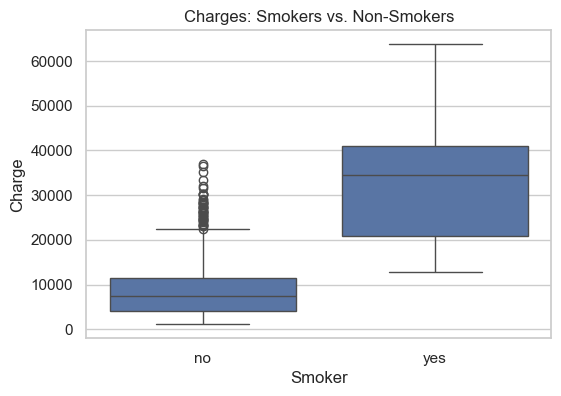

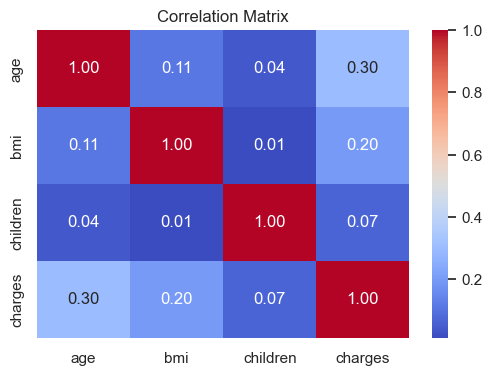

In [5]:
# Section 4: Univariate & Bivariate Exploration

# 4.1 — Univariate
num_cols = ['age', 'bmi', 'children', 'charges']
cat_cols = ['sex', 'smoker', 'region']
plot_numeric_distribution(df, num_cols)
plot_categorical_counts(df, cat_cols)

# 4.2 — Bivariate insights
# Age vs. Charges
sns.scatterplot(x='age', y='charges', data=df, alpha=0.6)
plt.title("Age vs. Charges")
plt.xlabel("Age")
plt.ylabel("Insurance Charge")
plt.show()

# BMI vs. Charges, colored by smoker
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.6)
plt.title("BMI vs. Charges by Smoking Status")
plt.xlabel("BMI")
plt.ylabel("Insurance Charge")
plt.legend(title="Smoker")
plt.show()

# Smoker vs. Charges boxplot
sns.boxplot(x='smoker', y='charges', data=df)
plt.title("Charges: Smokers vs. Non-Smokers")
plt.xlabel("Smoker")
plt.ylabel("Charge")
plt.show()

# Correlation heatmap (numeric only)
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [6]:
# Section 5: Feature Engineering

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# 5.1 — Extract region direction flags
df['region_north'] = df['region'].apply(lambda x: 'north' in x).astype(int)
df['region_west']  = df['region'].apply(lambda x: 'west'  in x).astype(int)

# 5.2 — Define preprocessing pipeline
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop='first'), ['sex', 'smoker']),
    ("num", StandardScaler(), ['age', 'bmi', 'children', 'region_north', 'region_west'])
])


In [7]:
# Section 6: Modeling & Evaluation 

# 6.0 — Imports
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 6.1 — Train/Test Split
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6.2 — Define Pipelines
models = {
    "LinearRegression": Pipeline([
        ("preprocessor", preprocessor),
        ("lr", LinearRegression())
    ]),
    "RandomForest": Pipeline([
        ("preprocessor", preprocessor),
        ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
}

# 6.3 — Train, Predict, and Evaluate
for name, pipe in models.items():
    # Fit on training data
    pipe.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = pipe.predict(X_test)
    
    # Calculate MAE and RMSE manually
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # 5-fold CV using MSE → convert to RMSE
    neg_mse_scores = cross_val_score(
        pipe, X, y, cv=5, scoring='neg_mean_squared_error'
    )
    rmse_scores = np.sqrt(-neg_mse_scores)
    cv_rmse_mean = rmse_scores.mean()
    cv_rmse_std  = rmse_scores.std()
    
    # Display results
    print(f"{name:<17}  MAE: {mae:8.2f}  RMSE: {rmse:8.2f}  CV-RMSE: {cv_rmse_mean:8.2f} ± {cv_rmse_std:4.2f}")


LinearRegression   MAE:  4185.93  RMSE:  5798.96  CV-RMSE:  6071.34 ± 195.36
RandomForest       MAE:  2575.63  RMSE:  4606.17  CV-RMSE:  4853.79 ± 354.06


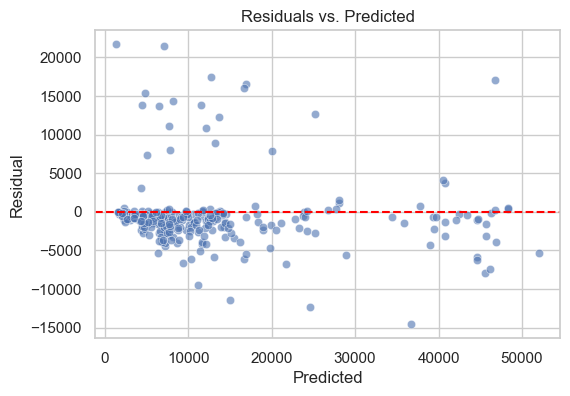

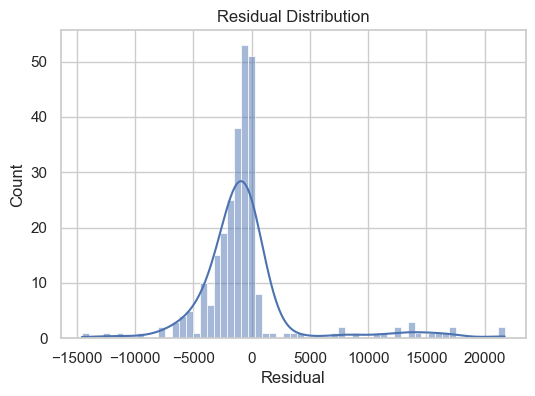

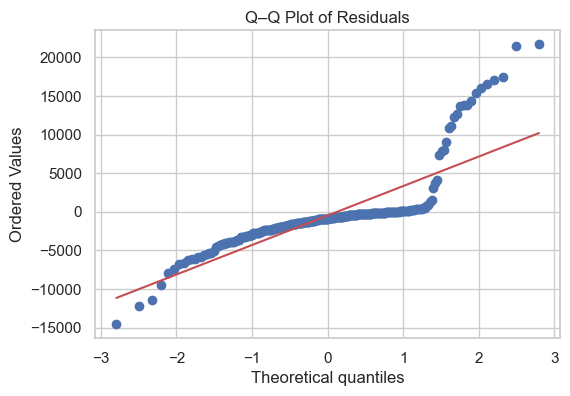

In [8]:
# Section 7: Residual Diagnostics

import numpy as np
from scipy import stats

# Use RandomForest residuals
rf_pred = models["RandomForest"].predict(X_test)
resid = y_test - rf_pred

# 7.1 — Residual vs. Predicted
sns.scatterplot(x=rf_pred, y=resid, alpha=0.6)
plt.axhline(0, ls='--', color='red')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

# 7.2 — Residual distribution
sns.histplot(resid, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# 7.3 — Q–Q plot
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.show()


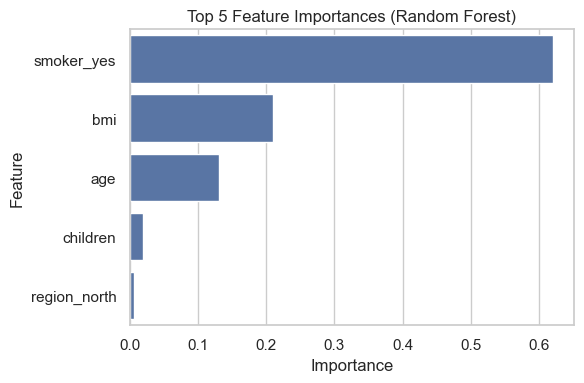

In [9]:
# Section 8: Feature Importance & Interpretation (Corrected)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 8.1 — Refit RandomForest on the full dataset to get final importances
rf_full = models["RandomForest"].fit(X, y)

# 8.2 — Extract feature names after preprocessing
# Note: the transformer step is named "preprocessor" (not "pre")
cat_features = rf_full.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(['sex', 'smoker'])
num_features = ['age', 'bmi', 'children', 'region_north', 'region_west']
feature_names = np.concatenate([cat_features, num_features])

# 8.3 — Retrieve importances and identify top 5
importances = rf_full.named_steps['rf'].feature_importances_
top_idx = np.argsort(importances)[::-1][:5]

# 8.4 — Plot the top 5 features
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=importances[top_idx], y=feature_names[top_idx])
plt.title("Top 5 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
